<a href="https://colab.research.google.com/github/meliluc/marketing-analytics-customer-insights-project/blob/main/02_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 - RFM Analysis & Customer Segmentation
Objetivo:
- Calcular métricas RFM (Recency, Frequency, Monetary).
- Segmentar clientes mediante clustering.
- Identificar perfiles de clientes para personalizar campañas.

## 01) Carga de dataset limpio

In [38]:
import pandas as pd
from pathlib import Path
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Cargas base
BASE_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights")
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
CLEAN_DIR = DATA_DIR / "clean"
REPORTS_DIR = BASE_DIR / "reports"
BI_DIR = BASE_DIR / "bi"
CLEAN_PATH = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/marketing_clean.csv")

# Generamos Customer_IDs con variabilidad realista con valores sintéticos (recordar que son datos artificales)
def generate_customer_ids_rng(n_rows, lam=4, max_freq=20, seed=2024):
    rng = np.random.default_rng(seed)
    n_customers = max(1, int(round(n_rows / lam)))
    freq = rng.poisson(lam, size=n_customers).clip(1, max_freq)

    diff = n_rows - int(freq.sum())
    if diff > 0:
        idx = rng.integers(0, n_customers, size=diff)
        np.add.at(freq, idx, 1)
    elif diff < 0:
        reducibles = np.where(freq > 1)[0]
        idx = rng.choice(reducibles, size=-diff, replace=True)
        np.add.at(freq, idx, -1)
    ids = np.repeat(np.arange(n_customers), freq)
    rng.shuffle(ids)
    return ids

# Chequeamos
df = pd.read_csv(CLEAN_PATH, parse_dates=["Date"])
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROAS,Location,...,Impressions,Engagement_Score,Customer_Segment,Date,CPA,CTR,CVR,CPC,CPM,ROI_pct
0,1,innovate industries,email,men 18-24,30 days,google ads,0.04,16174.0,6.29,chicago,...,1922,6,health & wellness,2021-01-01,16174.0,0.263267,0.04,31.964427,8415.192508,5.29
1,2,nexgen systems,email,women 35-44,60 days,google ads,0.12,11566.0,5.61,new york,...,7523,7,fashionistas,2021-01-02,11566.0,0.015419,0.12,99.706897,1537.418583,4.61
2,3,alpha innovations,influencer,men 25-34,30 days,youtube,0.07,10200.0,7.18,los angeles,...,7698,1,outdoor adventurers,2021-01-03,10200.0,0.075864,0.07,17.465753,1325.019486,6.18


## 02) Cálculo de variables RFM


Segmentación de los clientes según su comportamiento de compra, según:

- Recency = días desde la última interacción (usando Date).

- Frequency = número de interacciones por cliente.

- Monetary = gasto total (Acquisition_Cost o proxy de ingresos).



### ⚠️ Nota aclaratoria

El dataset utilizado no contiene un identificador único de cliente (Customer_ID),
por lo que no es posible calcular RFM de manera tradicional.

Para efectos prácticos y con fines de aprendizaje, se generó un **ID sintético de cliente**
a partir de `Campaign_ID`, agrupando campañas como si fueran transacciones de un mismo cliente.
De esta forma se puede aplicar la metodología RFM (Recency, Frequency, Monetary) y practicar
el flujo completo de segmentación y clustering, aun cuando los datos son sintéticos.
Por lo que más abajo realizaremos un cálculo simulado para dar sentido al RFM.

In [39]:
import numpy as np

# Copiamos el dataset limpio
df_rfm = df.copy()

# Simulación realista con ID sintético de asignación cliente-campañas
np.random.seed(42)

n_rows = len(df_rfm)          # total de campañas/filas
lambda_freq = 4.0             # media deseada de campañas por cliente
max_freq = 20                 # tope razonable por cliente
min_freq = 1

# Número aproximado de clientes según la media objetivo
n_customers = int(round(n_rows / lambda_freq))

# Frecuencias por cliente ~ Poisson, truncadas a [1, max_freq]
freq = np.random.poisson(lam=lambda_freq, size=n_customers)
freq = np.clip(freq, min_freq, max_freq)

# Ajuste para que la suma de asignaciones == n_rows
total = freq.sum()
if total < n_rows:
    # añadimos 1 a clientes aleatorios hasta igualar
    idx = np.random.choice(n_customers, size=(n_rows - total), replace=True)
    np.add.at(freq, idx, 1)
elif total > n_rows:
    # restamos 1 de clientes con freq>1 hasta igualar
    reducibles = np.where(freq > 1)[0]
    idx = np.random.choice(reducibles, size=(total - n_rows), replace=True)
    np.add.at(freq, idx, -1)

# Construimos el vector de Customer_IDs según su frecuencia y lo barajamos
customer_ids = np.repeat(np.arange(n_customers), freq)

# Barajamos las filas para romper correlación con el tiempo y asignamos IDs
rand_idx = np.random.permutation(n_rows)
df_rfm = df_rfm.iloc[rand_idx].copy()
df_rfm["Customer_ID"] = customer_ids[:n_rows]

# Volvemos a ordenar por fecha para análisis/plots temporales
df_rfm.sort_values("Date", inplace=True)
df_rfm.reset_index(drop=True, inplace=True)

print("Clientes simulados:", df_rfm["Customer_ID"].nunique())
df_rfm.head()


Clientes simulados: 49994


,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROAS,Location,...,Engagement_Score,Customer_Segment,Date,CPA,CTR,CVR,CPC,CPM,ROI_pct,Customer_ID
0,154761,datatech solutions,display,women 25-34,60 days,facebook,0.11,8322.0,5.95,los angeles,...,4,foodies,2021-01-01,8322.0,0.091550,0.11,13.084906,1197.927163,4.95,26492
1,43436,innovate industries,influencer,men 25-34,60 days,website,0.13,15748.0,6.52,chicago,...,10,foodies,2021-01-01,15748.0,0.139630,0.13,19.299020,2694.729637,5.52,42966
2,79571,innovate industries,display,men 25-34,30 days,facebook,0.07,9119.0,5.65,miami,...,4,tech enthusiasts,2021-01-01,9119.0,0.048093,0.07,78.612069,3780.679934,4.65,32464
3,7301,datatech solutions,display,men 25-34,60 days,google ads,0.05,11654.0,6.60,houston,...,4,tech enthusiasts,2021-01-01,11654.0,0.019819,0.05,79.278912,1571.255224,5.60,37542
4,159141,techcorp,social media,men 25-34,60 days,email,0.07,14238.0,5.94,miami,...,6,fashionistas,2021-01-01,14238.0,0.011132,0.07,135.600000,1509.541985,4.94,32505


In [40]:
# Cálculo RFM simulado para mejoramiento de los datos de análisis
import datetime as dt

# Fecha de referencia (última fecha + 1 día)
reference_date = df_rfm["Date"].max() + pd.Timedelta(days=1)

rfm = df_rfm.groupby("Customer_ID").agg({
    "Date": lambda x: (reference_date - x.max()).days,  # Recency
    "Campaign_ID": "count",                            # Frequency (nº campañas)
    "Acquisition_Cost": "sum"                          # Monetary (inversión total)
}).reset_index()

rfm.rename(columns={"Date":"Recency",
                    "Campaign_ID":"Frequency",
                    "Acquisition_Cost":"Monetary"}, inplace=True)

rfm.head()



,Customer_ID,Recency,Frequency,Monetary
0,0,38,5,71595.0
1,1,37,4,55585.0
2,2,138,4,50885.0
3,3,193,4,59350.0
4,4,67,2,23710.0


- Recency = siempre 1 → todas las compañías tienen campañas “ayer”. Esto pasa porque en el dataset todas las fechas son recientes o muy seguidas (dataset sintético).

- Frequency = decenas de miles → es porque estás contando todas las filas por Company. Cada fila = campaña, entonces se acumulan muchísimo.

- Monetary = centenas de millones → lo mismo, porque estás sumando Acquisition_Cost a lo bruto.

👉 En un dataset real, Recency tendría más variación, y Frequency/Monetary no serían tan enormes.

## 03) Exploración descriptiva de RFM


In [41]:
rfm.describe().T


,count,mean,std,min,25%,50%,75%,max
Customer_ID,49994.0,24998.781014,14433.450346,0.0,12500.25,24998.5,37497.75,49999.0
Recency,49994.0,86.519342,77.586439,1.0,27.00,63.0,125.00,365.0
Frequency,49994.0,4.000480,1.967684,1.0,3.00,4.0,5.00,16.0
Monetary,49994.0,50023.574989,26036.150548,5010.0,30635.50,47310.0,66161.00,202538.0


### Visualización práctica RFM


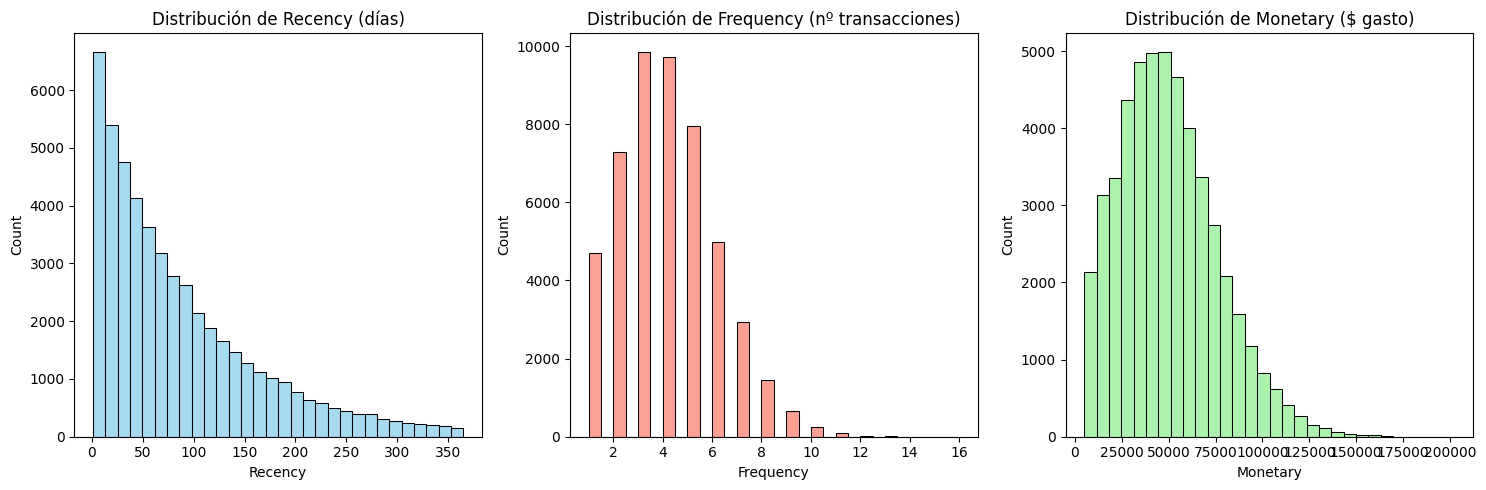

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuciones de R, F, M
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.histplot(rfm["Recency"], bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Distribución de Recency (días)")

sns.histplot(rfm["Frequency"], bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Distribución de Frequency (nº transacciones)")

sns.histplot(rfm["Monetary"], bins=30, ax=axes[2], color="lightgreen")
axes[2].set_title("Distribución de Monetary ($ gasto)")

plt.tight_layout()
plt.show()


### Boxplots por métrica


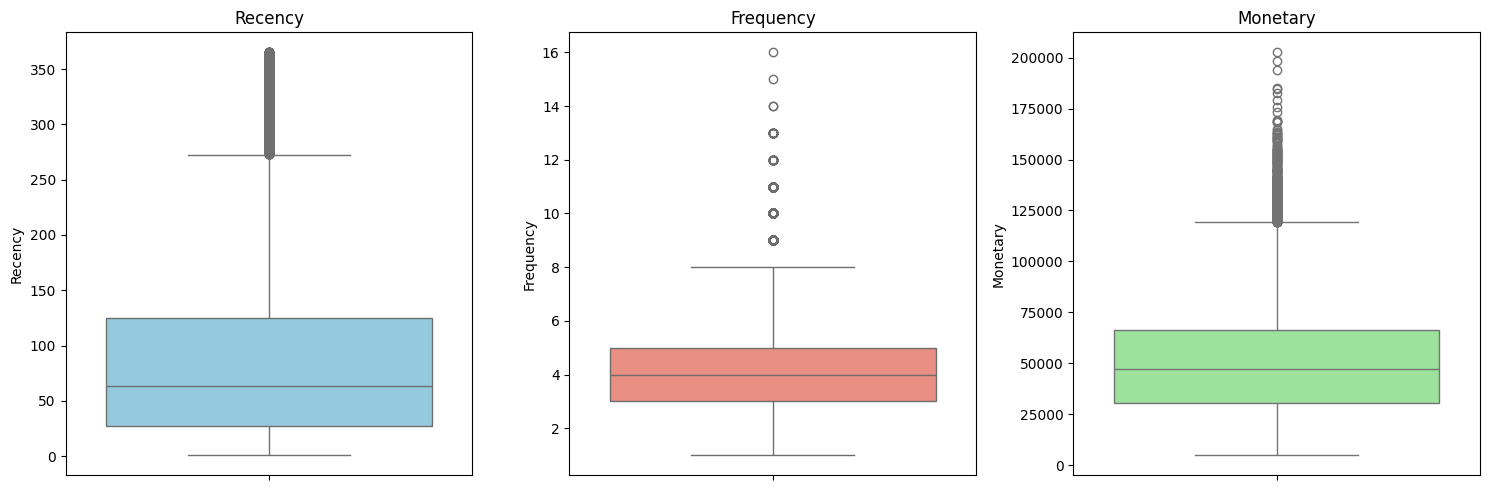

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(y=rfm["Recency"], ax=axes[0], color="skyblue")
axes[0].set_title("Recency")

sns.boxplot(y=rfm["Frequency"], ax=axes[1], color="salmon")
axes[1].set_title("Frequency")

sns.boxplot(y=rfm["Monetary"], ax=axes[2], color="lightgreen")
axes[2].set_title("Monetary")

plt.tight_layout()
plt.show()


## 04) Escalado de variables RFM


In [44]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos solo columnas RFM
X = rfm[["Recency", "Frequency", "Monetary"]]

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)
print("Primeras filas (escaladas):\n", X_scaled[:5])


Shape: (49994, 3)
Primeras filas (escaladas):
 [[-6.25364798e-01  5.07972696e-01  8.28526503e-01]
 [-6.38253778e-01 -2.43973278e-04  2.13606102e-01]
 [ 6.63533131e-01 -2.43973278e-04  3.30860595e-02]
 [ 1.37242699e+00 -2.43973278e-04  3.58214179e-01]
 [-2.51584399e-01 -1.01667731e+00 -1.01066546e+00]]


## 05) Preparación de datos para clustering

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = rfm[["Recency", "Frequency", "Monetary"]].values
X = StandardScaler().fit_transform(X)

# k=4 por defecto (rápido y suele ser buen punto de partida en RFM)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X)




## 05.a) Perfilado rápido (tabla para el portfolio)

In [46]:
cluster_profile = (
    rfm.groupby("Cluster")
       .agg(N=("Customer_ID", "count"),
            Recency_med=("Recency", "median"),
            Frequency_med=("Frequency", "median"),
            Monetary_med=("Monetary", "median"),
            Monetary_mean=("Monetary", "mean"))
       .sort_index()
       .round(1)
)
cluster_profile



,N,Recency_med,Frequency_med,Monetary_med,Monetary_mean
Cluster,,,,,
0,14824,58.0,3.0,31547.5,30482.1
1,18623,50.0,5.0,57870.0,58361.0
2,7948,32.0,7.0,89380.5,92941.7
3,8599,211.0,2.0,24392.0,25985.9


## 05.b) Gráficos

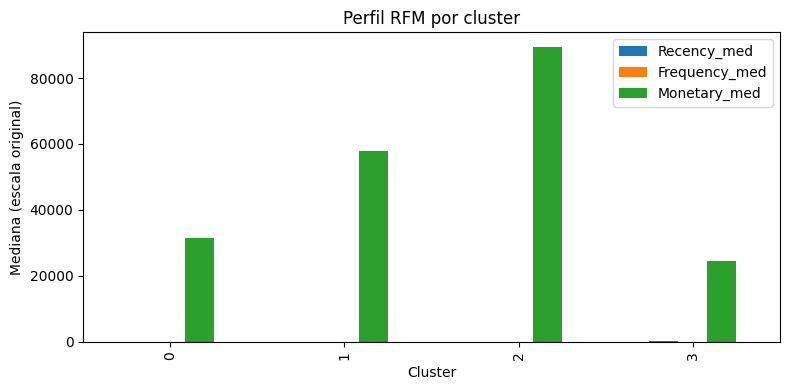

In [47]:
import matplotlib.pyplot as plt

X = rfm[["Recency", "Frequency", "Monetary"]].values
X = StandardScaler().fit_transform(X)

ax = cluster_profile[["Recency_med","Frequency_med","Monetary_med"]].plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Mediana (escala original)")
ax.set_title("Perfil RFM por cluster")
plt.tight_layout()
plt.show()


## 05.b) Gráfico del Codo

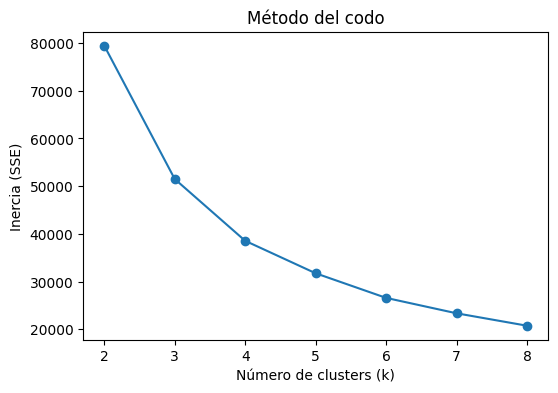

In [48]:
inertias = []
K_range = range(2, 9)  # probamos de 2 a 8 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, "-o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo")
plt.xticks(K_range)
plt.show()


## 06) Entrenamiento y asignación de clusters

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# El codo sugiere 4 (equilibrio entre mejora de SSE y simplicidad). Cambia aquí si decides otro k.
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X)

# Métrica rápida para validar la elección
sil = silhouette_score(X, rfm["Cluster"])
print(f"k = {best_k} | Silhouette Score: {sil:.3f}")

# Perfilado resumido (ideal para el informe)
cluster_profile = (
    rfm.groupby("Cluster")
       .agg(N=("Customer_ID","count"),
            Recency_med=("Recency","median"),
            Frequency_med=("Frequency","median"),
            Monetary_med=("Monetary","median"),
            Monetary_mean=("Monetary","mean"))
       .sort_index()
       .round(1)
)
cluster_profile


k = 4 | Silhouette Score: 0.357


,N,Recency_med,Frequency_med,Monetary_med,Monetary_mean
Cluster,,,,,
0,14824,58.0,3.0,31547.5,30482.1
1,18623,50.0,5.0,57870.0,58361.0
2,7948,32.0,7.0,89380.5,92941.7
3,8599,211.0,2.0,24392.0,25985.9


## 07) Visualización e interpretación de clusters

### Boxplots de R, F, M por cluster

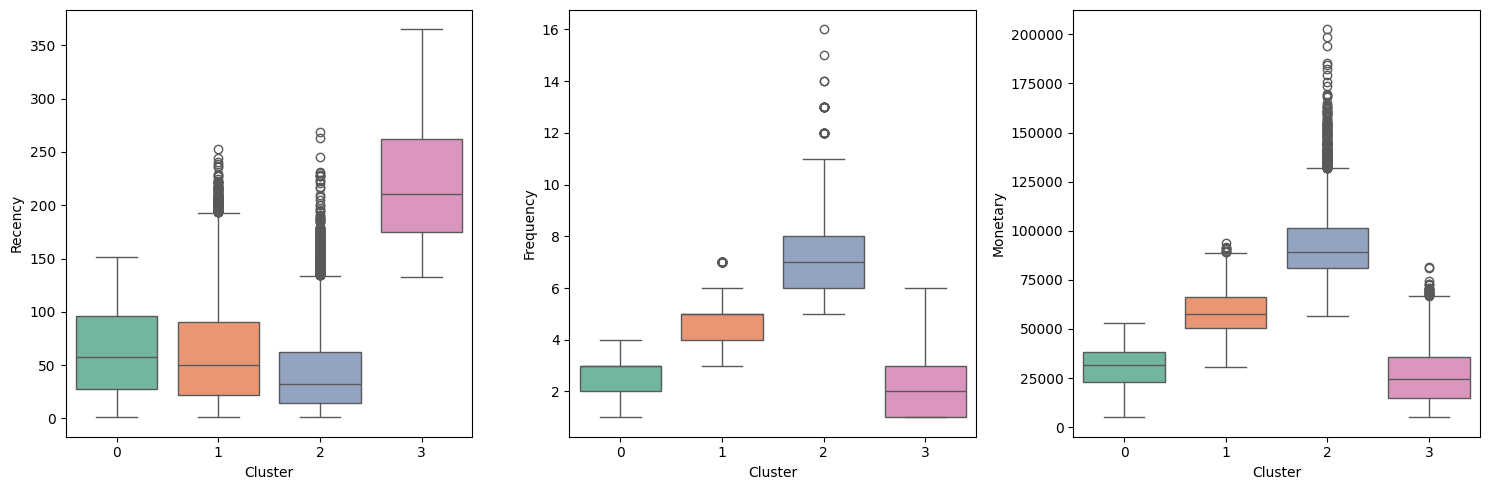

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.boxplot(x="Cluster", y="Recency", data=rfm, ax=axes[0], hue="Cluster", palette="Set2", legend=False)
sns.boxplot(x="Cluster", y="Frequency", data=rfm, ax=axes[1], hue="Cluster", palette="Set2", legend=False)
sns.boxplot(x="Cluster", y="Monetary", data=rfm, ax=axes[2], hue="Cluster", palette="Set2", legend=False)

plt.tight_layout()
plt.show()


### Tamaño de cada cluster

In [51]:
rfm["Cluster"].value_counts(normalize=True).mul(100).round(2)


,proportion
Cluster,
1,37.25
0,29.65
3,17.20
2,15.90


## 08) Hallazgos de segmentación RFM

**Conclusiones del clustering RFM**

Cluster 2 (VIP / High Value):
- Recency: muy baja (clientes recientes).
- Frequency: la más alta (6–12 campañas).
- Monetary: gasto significativamente superior al resto.
👉 Son los mejores clientes: frecuentes, activos y con alto gasto.
Estrategia: programas de fidelización, beneficios exclusivos, mantener engagement.

Cluster 1 (Buenos clientes / Potenciales VIP):
- Recency: relativamente baja (activos recientemente).
- Frequency: intermedia (3–6 campañas).
- Monetary: gasto medio-alto.
👉 Clientes prometedores, buen nivel de gasto y todavía activos.
Estrategia: incentivar con promociones personalizadas para que se conviertan en VIP.

Cluster 0 (Clientes regulares / Ocasionales):
- Recency: baja a media (participaron hace poco, pero no tanto como los VIP).
- Frequency: baja (1–3 campañas).
- Monetary: gasto bajo-medio.
👉 Clientes que compran poco y gastan moderadamente.
Estrategia: campañas de retención, aumentar frecuencia de compra.

Cluster 3 (Clientes inactivos / Perdidos):
- Recency: la más alta (última interacción hace mucho).
- Frequency: muy baja (1–2 campañas).
- Monetary: gasto bajo.
👉 Son clientes casi perdidos, bajo valor actual.
Estrategia: campañas de reactivación o “win-back”; si no responden, priorizar recursos en otros clusters.

**Resumen ejecutivo**
- El Cluster 2 (VIP) concentra el mayor valor económico → pequeño en número pero clave en ingresos.
- El Cluster 1 es el segmento a cultivar, puede escalar hacia VIP con incentivos adecuados.
- El Cluster 0 mantiene actividad pero bajo gasto → objetivo: aumentar frecuencia.
- El Cluster 3 representa clientes inactivos → se deben abordar con acciones específicas o dejar de invertir demasiado en ellos.

## 09) Exportamos archivos

In [53]:
# EXPORTES RFM
from pathlib import Path

REPORTS_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/reports")
CLEAN_DIR   = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean")

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# Exportar RFM a reports (para auditoría) y a clean (para BI)
rfm.to_csv(REPORTS_DIR / "rfm_clusters.csv", index=False)
print("✅ Exportado: reports/rfm_clusters.csv")

rfm.to_csv(CLEAN_DIR / "rfm_clusters.csv", index=False)
print("✅ Exportado: data/clean/rfm_clusters.csv")


✅ Exportado: reports/rfm_clusters.csv
✅ Exportado: data/clean/rfm_clusters.csv
